<b>Цель работы:</b> Выявление закономерностей из потока разнородной информации.
# Задание
Во время лабораторной работы студенты структурируют, обобщают и анализируют собранную при мониторинге информацию, выбирают подходящую технологию Data Mining, разрабатывают и реализуют алгоритм поиска закономерностей в собранных данных.

---

## Выбор данных
Для выполнения лабораторной работы было решено взять данные мониторинга системы умного дома. В квартире установлены такие приборы, входящие в систему умного дома, как лампочки, настольная лампа, чайник, телевизор и некторые другие. Все они объединены в единую систему под управлением Home Assistant. Home Assistant позволяет не только управлять работой и параметрами устройств, выстраивать сценарии автоматизации, но и ведёт сбор и хранение информации о состоянии устройств. Было решено воспользоваться этой особенностью системы и использовать данные об устройствах умного дома.

В Home Assistant каждый прибор представлен сущностью

Система состоит из крайне разнородных устройств, но для упрощения было решено рассматривать только осветительные приборы дома. О них можно получить следующую информацию из базы данных: идентификатор

In [2]:
import pandas as pd
import numpy as np
import json

from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split

from matplotlib import pyplot as plt
from sklearn import tree
from matplotlib.colors import ListedColormap

In [3]:
DATA_PATH = "./states-export.csv"

def CustomParser(data):
    import json
    j1 = json.loads(data)
    return j1

df = pd.read_csv(DATA_PATH, converters={'shared_attrs':CustomParser})
df.head()

,entity_id,state_id,state,old_state_id,last_changed,last_updated,shared_attrs
0,light.wiz_bulb1,122386,on,NaN,NaN,2022-11-06 09:46:09.108812,"{'min_color_temp_kelvin': 2702, 'max_color_tem..."
1,light.kitchen_lamp,122387,on,NaN,NaN,2022-11-06 09:46:09.111577,"{'min_color_temp_kelvin': 2702, 'max_color_tem..."
2,light.wiz_bulb_2,122388,on,NaN,NaN,2022-11-06 09:46:09.178759,"{'min_color_temp_kelvin': 2702, 'max_color_tem..."
3,light.wiz_bulb_2,122391,on,122388.0,2022-11-06 09:46:09.178759,2022-11-06 09:46:12.714160,"{'min_color_temp_kelvin': 2702, 'max_color_tem..."
4,light.kitchen_lamp,122392,on,122387.0,2022-11-06 09:46:09.111577,2022-11-06 09:46:12.718751,"{'min_color_temp_kelvin': 2702, 'max_color_tem..."


In [4]:
json_keys = ['color_mode','brightness','effect','hs_color','rgb_color', 'color_temp']
json_attrs = df['shared_attrs'].apply(pd.Series).filter(items=json_keys)
df[json_keys] = json_attrs
df.head()

,entity_id,state_id,state,old_state_id,last_changed,last_updated,shared_attrs,color_mode,brightness,effect,hs_color,rgb_color,color_temp
0,light.wiz_bulb1,122386,on,NaN,NaN,2022-11-06 09:46:09.108812,"{'min_color_temp_kelvin': 2702, 'max_color_tem...",brightness,255.0,Fall,NaN,NaN,NaN
1,light.kitchen_lamp,122387,on,NaN,NaN,2022-11-06 09:46:09.111577,"{'min_color_temp_kelvin': 2702, 'max_color_tem...",brightness,255.0,Fall,NaN,NaN,NaN
2,light.wiz_bulb_2,122388,on,NaN,NaN,2022-11-06 09:46:09.178759,"{'min_color_temp_kelvin': 2702, 'max_color_tem...",brightness,255.0,Fall,NaN,NaN,NaN
3,light.wiz_bulb_2,122391,on,122388.0,2022-11-06 09:46:09.178759,2022-11-06 09:46:12.714160,"{'min_color_temp_kelvin': 2702, 'max_color_tem...",color_temp,255.0,Warm White,"[28.391, 65.659]","[255, 166, 87]",370.0
4,light.kitchen_lamp,122392,on,122387.0,2022-11-06 09:46:09.111577,2022-11-06 09:46:12.718751,"{'min_color_temp_kelvin': 2702, 'max_color_tem...",color_temp,255.0,Fall,"[28.391, 65.659]","[255, 166, 87]",370.0


In [5]:
import ciso8601

def min_of_day(str):
    t = ciso8601.parse_datetime(str)
    min = t.hour*60 + t.minute
    return min

def split_rgb(lst):
    if type(lst) == float:
        return [np.nan, np.nan, np.nan]
    else:
        return lst

df['update_time'] = df['last_updated'].apply(min_of_day)
df[['r_color','g_color','b_color']] = list(df.rgb_color.apply(split_rgb))
df.head()

,entity_id,state_id,state,old_state_id,last_changed,last_updated,shared_attrs,color_mode,brightness,effect,hs_color,rgb_color,color_temp,update_time,r_color,g_color,b_color
0,light.wiz_bulb1,122386,on,NaN,NaN,2022-11-06 09:46:09.108812,"{'min_color_temp_kelvin': 2702, 'max_color_tem...",brightness,255.0,Fall,NaN,NaN,NaN,586,NaN,NaN,NaN
1,light.kitchen_lamp,122387,on,NaN,NaN,2022-11-06 09:46:09.111577,"{'min_color_temp_kelvin': 2702, 'max_color_tem...",brightness,255.0,Fall,NaN,NaN,NaN,586,NaN,NaN,NaN
2,light.wiz_bulb_2,122388,on,NaN,NaN,2022-11-06 09:46:09.178759,"{'min_color_temp_kelvin': 2702, 'max_color_tem...",brightness,255.0,Fall,NaN,NaN,NaN,586,NaN,NaN,NaN
3,light.wiz_bulb_2,122391,on,122388.0,2022-11-06 09:46:09.178759,2022-11-06 09:46:12.714160,"{'min_color_temp_kelvin': 2702, 'max_color_tem...",color_temp,255.0,Warm White,"[28.391, 65.659]","[255, 166, 87]",370.0,586,255.0,166.0,87.0
4,light.kitchen_lamp,122392,on,122387.0,2022-11-06 09:46:09.111577,2022-11-06 09:46:12.718751,"{'min_color_temp_kelvin': 2702, 'max_color_tem...",color_temp,255.0,Fall,"[28.391, 65.659]","[255, 166, 87]",370.0,586,255.0,166.0,87.0


In [65]:
lamps = ['light.living_room_lamp']
params = ['update_time','state', 'color_mode', 'brightness', 'effect','r_color','g_color','b_color' , 'color_temp']
sdf = df[df.entity_id.isin(lamps)][params]
sdf = sdf[sdf.state != 'unavailable']
sdf


,update_time,state,color_mode,brightness,effect,r_color,g_color,b_color,color_temp
13,757,on,brightness,255.0,Fall,NaN,NaN,NaN,NaN
17,757,on,color_temp,255.0,Fall,255.0,166.0,87.0,370.0
20,757,on,color_temp,255.0,Warm White,255.0,166.0,87.0,370.0
29,885,off,NaN,NaN,NaN,NaN,NaN,NaN,NaN
34,1060,on,brightness,255.0,Fall,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...
1136,1072,on,color_temp,255.0,TV time,255.0,166.0,87.0,370.0
1138,1072,on,brightness,255.0,TV time,NaN,NaN,NaN,NaN
1145,1241,off,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1153,1297,on,brightness,255.0,Fall,NaN,NaN,NaN,NaN


In [66]:
def handle_non_numerical_data(df):
    copy = df.copy()
    columns = copy.columns.values
    decoders = {}
    for column in columns:
        text_digit_vals = {}
        def convert_to_int(val):
            return text_digit_vals[val]

        if copy[column].dtype != np.int64 and copy[column].dtype != np.float64:
            column_contents = copy[column].values.tolist()
            unique_elements = set(column_contents)
            x = 0
            for unique in unique_elements:
                if unique not in text_digit_vals:
                    text_digit_vals[unique] = x
                    x+=1

            copy[column] = list(map(convert_to_int, copy[column]))
            decoders[column] = text_digit_vals


    return copy.fillna(0), decoders

coded, decoders = handle_non_numerical_data(sdf)

In [67]:
coded.head()

,update_time,state,color_mode,brightness,effect,r_color,g_color,b_color,color_temp
13,757,0,1,255.0,2,0.0,0.0,0.0,0.0
17,757,0,3,255.0,2,255.0,166.0,87.0,370.0
20,757,0,3,255.0,1,255.0,166.0,87.0,370.0
29,885,1,0,0.0,0,0.0,0.0,0.0,0.0
34,1060,0,1,255.0,2,0.0,0.0,0.0,0.0


In [68]:
decoders

{'state': {'on': 0, 'off': 1},
 'color_mode': {nan: 0, 'brightness': 1, 'rgbw': 2, 'color_temp': 3},
 'effect': {nan: 0, 'Warm White': 1, 'Fall': 2, 'TV time': 3, 'Romance': 4}}

In [69]:
train, test = train_test_split(coded)

In [70]:
x_state, y_state = ['update_time'], ['state']
x_effect, y_effect = ['update_time'], ['effect']
x_color, y_color = ['update_time', 'state', 'effect'], ['brightness','r_color','g_color','b_color', 'color_temp']

In [266]:
state = DecisionTreeClassifier(max_leaf_nodes=18)
state.fit(train[x_state], train[y_state])
state.score(test[x_state], test[y_state])


0.8333333333333334

In [257]:
effect = DecisionTreeClassifier(max_leaf_nodes=18)
effect.fit(train[x_effect], train[y_effect])
effect.score(test[x_effect], test[y_effect])


0.5185185185185185

In [258]:
color = DecisionTreeRegressor(max_leaf_nodes=10)
color.fit(train[x_color], train[y_color])
color.score(test[x_color], test[y_color])


0.5472152302472918

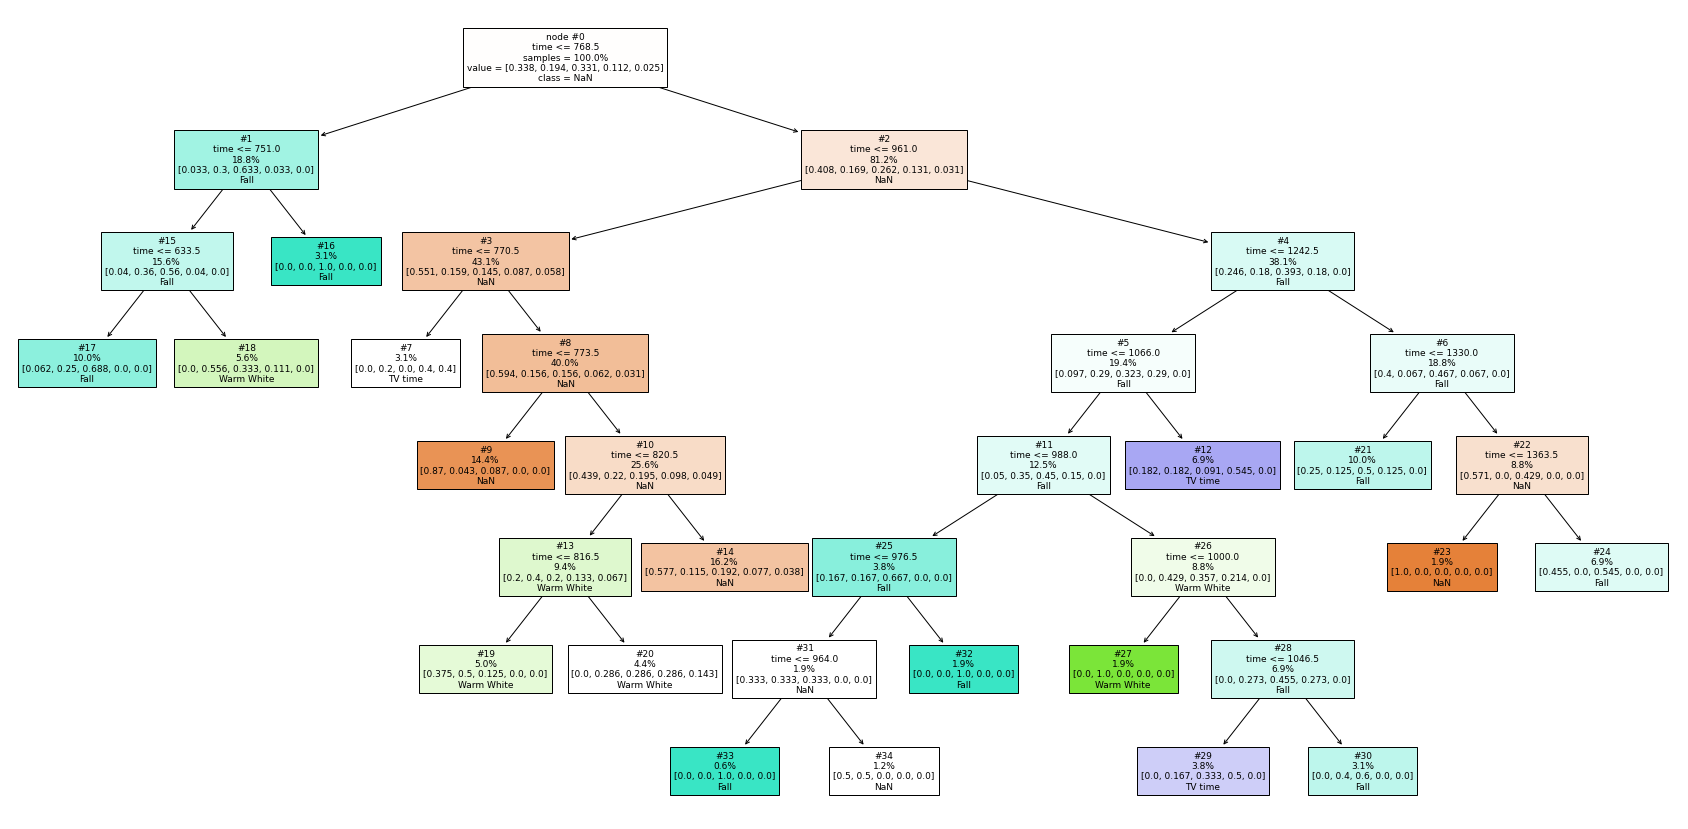

In [259]:
effect_classes = list(decoders['effect'].keys())
effect_classes[0] = 'NaN'
plt.figure("Decision Tree", figsize=[30,15])
tree.plot_tree(effect, feature_names=['time'], impurity=False, node_ids=True, proportion=True, fontsize=9, filled=True, class_names=effect_classes, label='root')
plt.show()

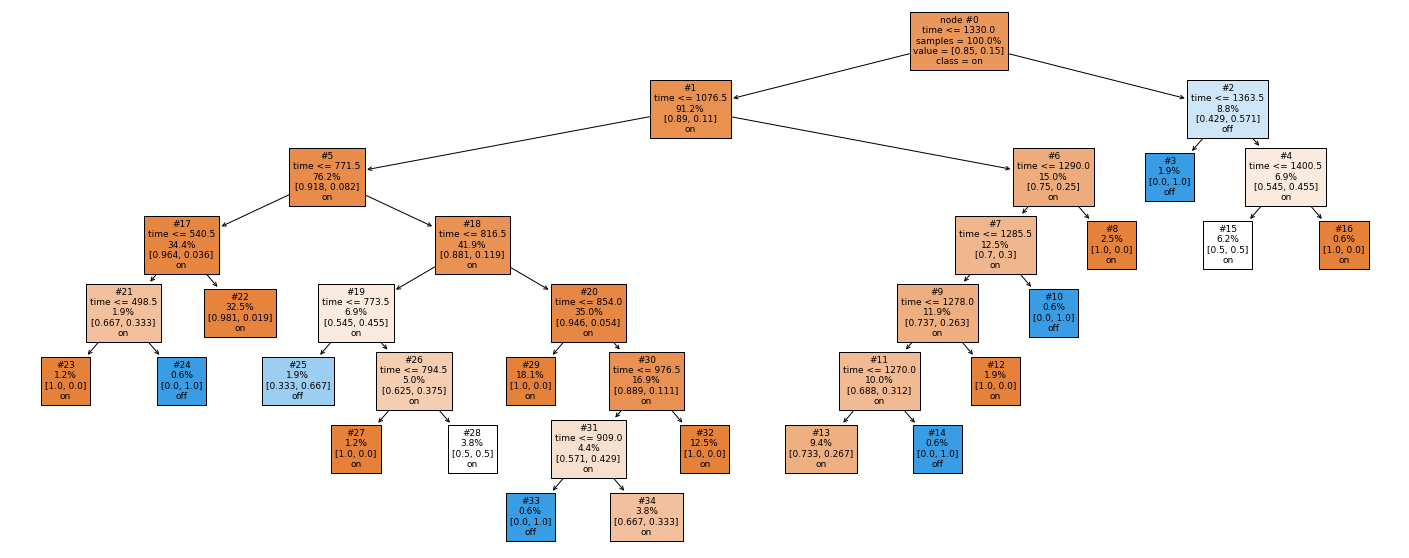

In [262]:
state_classes = list(decoders['state'].keys())
plt.figure("Decision Tree", figsize=[25,10])
tree.plot_tree(state, feature_names=['time'], impurity=False, node_ids=True, proportion=True, fontsize=9, filled=True, class_names=state_classes, label='root')
plt.show()

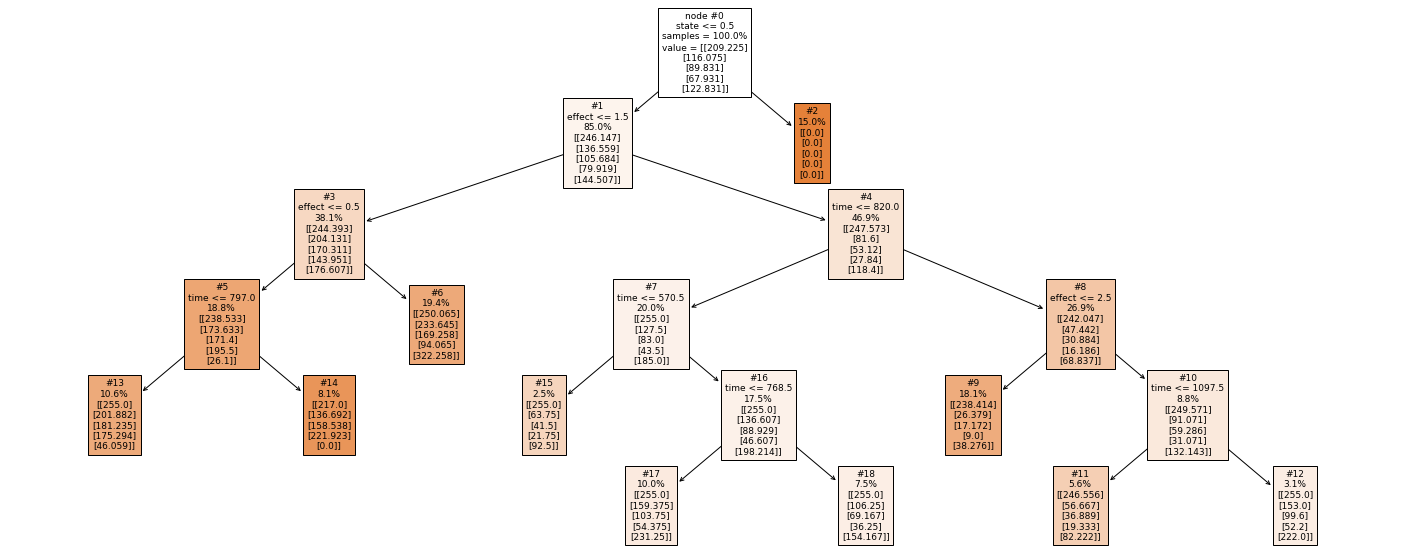

In [263]:
plt.figure("Decision Tree", figsize=[25,10])
tree.plot_tree(color, feature_names=['time', 'state', 'effect', ], impurity=False, node_ids=True, proportion=True, fontsize=9, filled=True, label='root')
plt.show()

In [270]:
timescale = np.arange(sdf.update_time.min(), 24*60, 1)

([<matplotlib.axis.YTick at 0x7fdc4468de50>,
 [Text(0, 0, 'on'), Text(0, 1, 'off')])

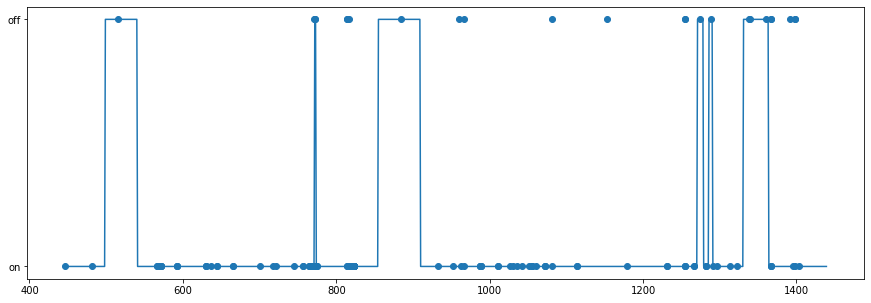

In [271]:
plt.figure("State based on time", figsize=[15,5])
plt.scatter(train[x_state], train[y_state])
plt.plot(timescale, state.predict(timescale.reshape(-1, 1)))
plt.yticks(list(decoders['state'].values()), list(decoders['state'].keys()))

([<matplotlib.axis.YTick at 0x7fdc3f4d29a0>,
 [Text(0, 0, 'NaN'),
  Text(0, 1, 'Warm White'),
  Text(0, 2, 'Fall'),
  Text(0, 3, 'TV time'),
  Text(0, 4, 'Romance')])

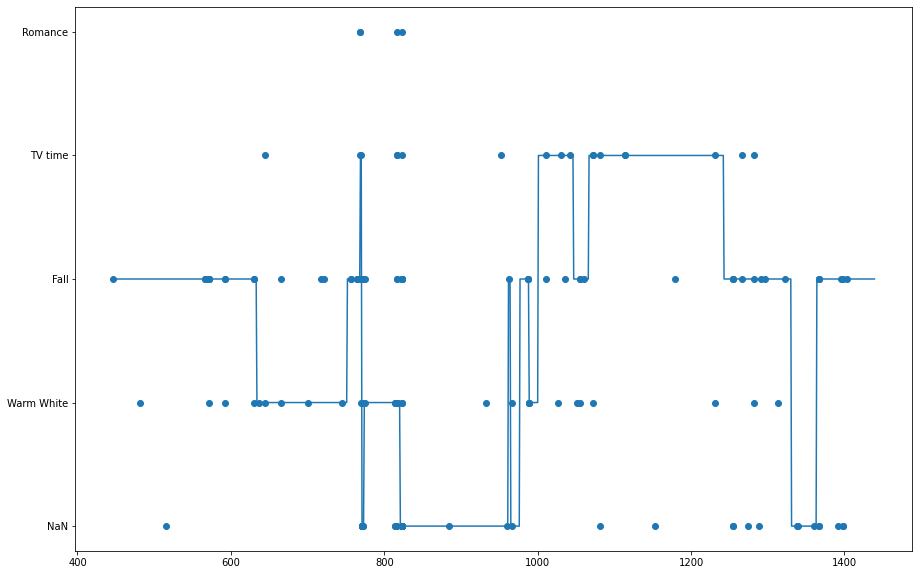

In [235]:
plt.figure("Effect based on time", figsize=[15,10])
plt.scatter(train[x_effect], train[y_effect])
plt.plot(timescale, effect.predict(timescale.reshape(-1, 1)))
plt.yticks(list(decoders['effect'].values()), effect_classes)

In [236]:
timescale_effect = pd.DataFrame(data=timescale)
timescale_effect['state'] = decoders['state']['on']
timescale_effect['effect'] = decoders['effect'][np.nan]
timescale_effect.head()

,0,state,effect
0,447,0,0
1,448,0,0
2,449,0,0
3,450,0,0
4,451,0,0


In [237]:
brightness = color.predict(timescale_effect)[:,0]
rgb = color.predict(timescale_effect)[:,1:4]
rgb = np.floor(rgb)

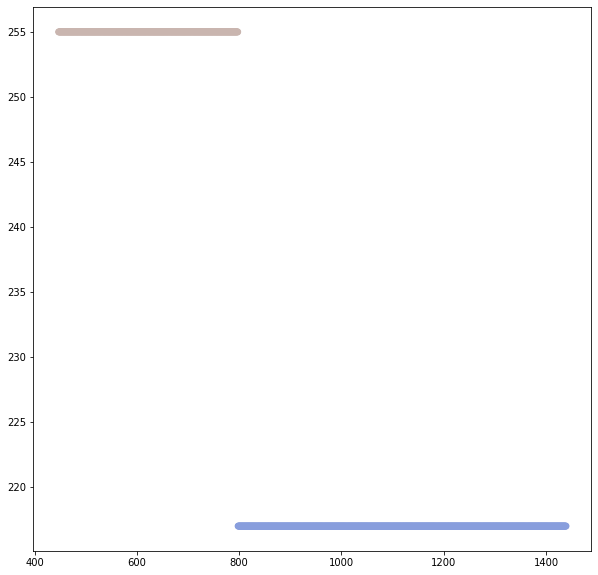

In [238]:
plt.figure("Brightness and color based on time", figsize=[10,10])
plt.scatter(timescale, brightness, c=rgb/255.0)